In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Read data

In [2]:
test_df = pd.read_csv("train.csv")

In [3]:
test_df.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
156,157,1,3,"Gilnagh, Miss. Katherine ""Katie""",female,16.0,0,0,35851,7.7333,NaN,Q
190,191,1,2,"Pinsky, Mrs. (Rosa)",female,32.0,0,0,234604,13.0000,NaN,S
85,86,1,3,"Backstrom, Mrs. Karl Alfred (Maria Mathilda Gu...",female,33.0,3,0,3101278,15.8500,NaN,S
181,182,0,2,"Pernot, Mr. Rene",male,NaN,0,0,SC/PARIS 2131,15.0500,NaN,C
68,69,1,3,"Andersson, Miss. Erna Alexandra",female,17.0,4,2,3101281,7.9250,NaN,S
30,31,0,1,"Uruchurtu, Don. Manuel E",male,40.0,0,0,PC 17601,27.7208,NaN,C
582,583,0,2,"Downton, Mr. William James",male,54.0,0,0,28403,26.0000,NaN,S
601,602,0,3,"Slabenoff, Mr. Petco",male,NaN,0,0,349214,7.8958,NaN,S
787,788,0,3,"Rice, Master. George Hugh",male,8.0,4,1,382652,29.1250,NaN,Q
284,285,0,1,"Smith, Mr. Richard William",male,NaN,0,0,113056,26.0000,A19,S


### Explore and Clean data

In [4]:
test_df = test_df.drop(['PassengerId','Ticket','Cabin','Name'], axis=1)

In [5]:
test_df.shape

(891, 8)

In [6]:
test_df.dtypes

Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object

In [7]:
test_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


#### Identifying classes of each categorical variable

In [8]:
for key in test_df.columns:
    if test_df[key].dtype == "object":
        print(test_df[key].value_counts())
        

male      577
female    314
Name: Sex, dtype: int64
S    644
C    168
Q     77
Name: Embarked, dtype: int64


#### Identifying missing values

In [9]:
test_df.isnull().sum() 

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

#### Filling missing values 

In [10]:
test_df = test_df.fillna(method='pad')

#### Label encoding categorical variables

In [11]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder() 

In [12]:
for key in test_df.columns:
    if test_df[key].dtype == "object":
        test_df[key]= label_encoder.fit_transform(test_df[key]) 
        test_df[key].unique() 
        print(test_df[key].value_counts())

1    577
0    314
Name: Sex, dtype: int64
2    644
0    169
1     78
Name: Embarked, dtype: int64


In [13]:
test_df.sample(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
285,0,3,1,33.00,0,0,8.6625,0
288,1,2,1,42.00,0,0,13.0000,2
832,0,3,1,0.83,0,0,7.2292,0
506,1,2,0,33.00,0,2,26.0000,2
172,1,3,0,1.00,1,1,11.1333,2


#### Examining correlation

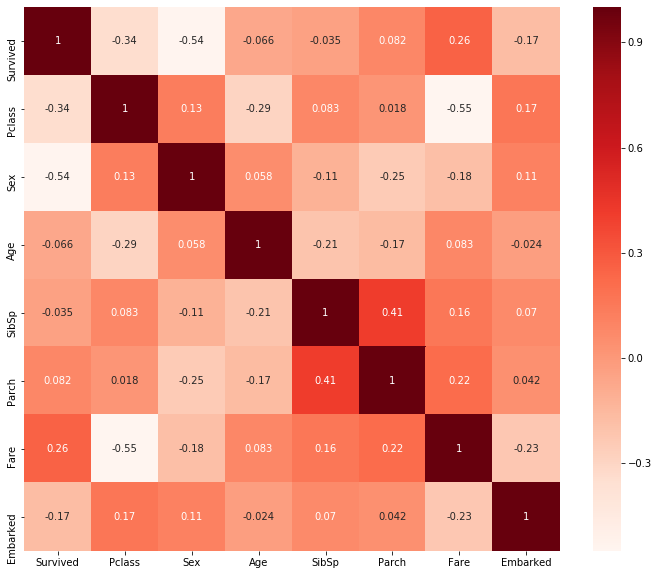

In [14]:
plt.figure(figsize=(12,10))
corr = test_df.corr()
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)
plt.show()

In [15]:
X = test_df.drop("Survived", axis=1)
Y = test_df["Survived"]

In [16]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1)

In [17]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(801, 7)
(90, 7)
(801,)
(90,)


#### Convert data into tensors

In [18]:
import torch
import torch.nn as nn
from torch.nn import functional as F

In [19]:
Xtrain_ = torch.from_numpy(x_train.values).float()
Xtest_ = torch.from_numpy(x_test.values).float()

In [20]:
Xtrain_.shape

torch.Size([801, 7])

Y parameters have shape 801 X 1 but we need those in shape 1 X 801<br>
Our loss function doesnt support multi-target, our target should be 1D Tensor
i.e 1 row containing all the labels<br>

In [21]:
Ytrain_ = torch.from_numpy(y_train.values).view(1,-1)[0]
Ytest_ = torch.from_numpy(y_test.values).view(1,-1)[0]

In [22]:
Ytrain_.shape

torch.Size([801])

## Creating a classifier


we have 7 features therefore input size is 7 and we want 2 discrete outputs 

In [23]:
input_size = 7
output_size = 2
hidden_size = 200

#### Define a neural network class from which to create our model

We create a class named Net which inherits nn.Module(Base class for all neural network modules.)<br>

<b>super :</b> This is calling the \__init__() method of the parent class(nn.Module)

<b>fc1 to fc3 :</b>  Applies a linear transformation to the incoming data: y=Wx+b<br>
Parameters :<br>
in_features – size of each input sample<br>
out_features – size of each output sample<br>
bias – If set to False, the layer will not learn an additive bias. Default: True<br>

<b>Sigmoid : </b>Applies the element-wise function Sigmoid(x)= 1 / (1+exp(−x))

<b>log_softmax :</b>
Softmax applies the Softmax() function to an n-dimensional input Tensor rescaling them so that the elements of the n-dimensional output Tensor lie in the range (0,1) and sum to 1<br>
While mathematically equivalent to log(softmax(x)), doing these two operations separately is slower, and numerically unstable. This function uses an alternative formulation to compute the output and gradient correctly.<br>
Parameters:<br>
dim(int) – A dimension along which Softmax will be computed (so every slice along dim will sum to 1).


In [24]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        X = torch.sigmoid((self.fc1(X)))
        X = torch.sigmoid(self.fc2(X))
        X = self.fc3(X)

        return F.log_softmax(X, dim=-1)

In [25]:
model = Net()

#### Defining optimizer and loss function

In [26]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr = 0.001)

loss_fn = nn.CrossEntropyLoss()

#### Training the model

Optimizer.zero_grad:
* Before the backward pass, use the optimizer object to zero all of the gradients for the variables it will update (which are the learnable weights of the model)

Foward Pass:
* Predicting Y with input data X

Finding training Loss:
* Finding difference between Y_train_tensor and Y_pred using NLLLoss() function defined above


Back Propogation:
* back propogation is done by simply loss.backward() function


In [27]:
epochs = 3500

for epoch in range(epochs):

    optimizer.zero_grad()
    Ypred = model(Xtrain_)

    loss = loss_fn(Ypred , Ytrain_)
    loss.backward()

    optimizer.step()
        
    if epoch % 100 == 0:
        print ('Epoch', epoch, 'loss', loss.item())

Epoch 0 loss 0.6868308782577515
Epoch 100 loss 0.5322456359863281
Epoch 200 loss 0.4043535590171814
Epoch 300 loss 0.37662672996520996
Epoch 400 loss 0.35628241300582886
Epoch 500 loss 0.3402444124221802
Epoch 600 loss 0.31837186217308044
Epoch 700 loss 0.3028843402862549
Epoch 800 loss 0.290351927280426
Epoch 900 loss 0.27972444891929626
Epoch 1000 loss 0.2706383466720581
Epoch 1100 loss 0.26559868454933167
Epoch 1200 loss 0.2555696368217468
Epoch 1300 loss 0.24914279580116272
Epoch 1400 loss 0.24350666999816895
Epoch 1500 loss 0.23838680982589722
Epoch 1600 loss 0.23375028371810913
Epoch 1700 loss 0.22914616763591766
Epoch 1800 loss 0.22507596015930176
Epoch 1900 loss 0.22217857837677002
Epoch 2000 loss 0.21761998534202576
Epoch 2100 loss 0.21426092088222504
Epoch 2200 loss 0.21235887706279755
Epoch 2300 loss 0.2082749307155609
Epoch 2400 loss 0.20550644397735596
Epoch 2500 loss 0.2035471796989441
Epoch 2600 loss 0.20216231048107147
Epoch 2700 loss 0.19842946529388428
Epoch 2800 loss

In [28]:
model.eval()

Net(
  (fc1): Linear(in_features=7, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=2, bias=True)
)

In [29]:
predict_out = model(Xtest_)
_, predict_y = torch.max(predict_out, 1)

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print ('prediction accuracy', accuracy_score(Ytest_.data, predict_y.data))
print ('precision', precision_score(Ytest_.data, predict_y.data))
print ('recall', recall_score(Ytest_.data, predict_y.data))
print ('f1_score',f1_score(Ytest_.data, predict_y.data))


prediction accuracy 0.8
precision 0.71875
recall 0.71875
f1_score 0.71875


#### Test the model on new data

In [32]:
df = pd.read_csv("test.csv")

In [33]:
df.sample(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
352,1244,2,"Dibden, Mr. William",male,18.0,0,0,S.O.C. 14879,73.50,NaN,S
383,1275,3,"McNamee, Mrs. Neal (Eileen O'Leary)",female,19.0,1,0,376566,16.10,NaN,S
395,1287,1,"Smith, Mrs. Lucien Philip (Mary Eloise Hughes)",female,18.0,1,0,13695,60.00,C31,S
94,986,1,"Birnbaum, Mr. Jakob",male,25.0,0,0,13905,26.00,NaN,C
102,994,3,"Foley, Mr. William",male,NaN,0,0,365235,7.75,NaN,Q


In [34]:
test_df = df.drop(['PassengerId','Ticket','Cabin','Name'], axis=1)

In [35]:
for key in test_df.columns:
    if test_df[key].dtype == "object":
        test_df[key]= label_encoder.fit_transform(test_df[key]) 
        test_df[key].unique() 

In [36]:
test_ = torch.from_numpy(test_df.values).float()

In [37]:
predict_out = model(test_)
_, predict_y = torch.max(predict_out, 1)

In [38]:
y = predict_y.numpy()

In [39]:
d = {'PassengerId': df['PassengerId'], 'Survived': y}
result = pd.DataFrame(data=d)

In [41]:
result.to_csv("submission.csv", index=False)